In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

traffic = pd.read_excel('traffic_clean.xlsx', sheet_name='traffic', skiprows=2)

In [2]:
# Visual scan on how the data look like
traffic.head()

,Date,Day,Fiscal Week,Month,Total Visits,Email Visits,SEO Visits,SEM Visits,Direct Visits,Referrer Visits,...,Push Adjst (w/ Email segment),Old_Push (Detail),Marketing,Triggered/Transactional,Email (Mkting + Triggered),Direct_New,Push_New,Organic Visits,Retention Visits,Advertising Visits
0,2014-12-29,Monday,FW01,2014-12-31,937017.486270,64149.43233,284503.6446,189701.56158,321699.734857,37663.117137,...,NaN,0,0,0,64149.43233,NaN,NaN,53584.500500,64149.43233,619683.867566
1,2014-12-30,Tuesday,FW01,2014-12-31,924383.376063,83097.55709,270184.2030,178411.60631,316377.082989,37114.755995,...,NaN,0,0,0,83097.55709,NaN,NaN,53640.160863,83097.55709,561214.550109
2,2014-12-31,Wednesday,FW01,2014-12-31,654935.636223,60717.39143,269422.1734,127361.53048,222226.740699,31909.210009,...,NaN,0,0,0,60717.39143,NaN,NaN,45851.132743,60717.39143,474457.302598
3,2015-01-01,Thursday,FW01,2015-01-31,922650.563334,172243.40082,272754.2445,153240.45000,298102.775171,33227.693502,...,NaN,0,0,0,172243.40082,470346.175991,0.0,518660.703844,172243.40082,512027.629320
4,2015-01-02,Friday,FW01,2015-01-31,820409.589283,78097.15257,267730.7162,158850.05884,281170.465319,34612.102031,...,NaN,0,0,0,78097.15257,359267.617889,0.0,408855.945473,78097.15257,505964.718914


In [3]:
# review data type
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 29 columns):
Date                             1464 non-null datetime64[ns]
Day                              1464 non-null object
Fiscal Week                      1464 non-null object
Month                            1464 non-null datetime64[ns]
Total Visits                     1464 non-null float64
Email Visits                     1464 non-null float64
SEO Visits                       1464 non-null float64
SEM Visits                       1464 non-null float64
Direct Visits                    1464 non-null float64
Referrer Visits                  1464 non-null float64
Organic Social Visits            1464 non-null float64
Paid Social Visits               1464 non-null float64
Affiliate Visits                 1464 non-null float64
Display Visits                   1464 non-null float64
New_Push (LT Channel)            640 non-null float64
Desktop (None)                   456 non-null float64
Mwe

In [5]:
# check for null
traffic.isnull().sum()

Date                                0
Day                                 0
Fiscal Week                         0
Month                               0
Total Visits                        0
Email Visits                        0
SEO Visits                          0
SEM Visits                          0
Direct Visits                       0
Referrer Visits                     0
Organic Social Visits               0
Paid Social Visits                  0
Affiliate Visits                    0
Display Visits                      0
New_Push (LT Channel)             824
Desktop (None)                   1008
Mweb (None)                      1008
iPhone (None)                    1008
Android (None)                   1008
Push Adjst (w/ Email segment)     824
Old_Push (Detail)                   0
Marketing                           0
Triggered/Transactional             0
Email (Mkting + Triggered)          0
Direct_New                          3
Push_New                            3
Organic Visi

In [6]:
# Set index to be the Date column, which is already recognzied as datetime type, no conversion is needed
traffic.set_index('Date', inplace=True)

In [7]:
# For this exercise, we only want to look at SEO traffic
traffic_org = traffic[['Day', 'Fiscal Week','SEO Visits']]

In [8]:
# change column name for easier coding
traffic_org.columns = ['day', 'fis_wk','seo_visits']

In [9]:
# data after September 2018 is unknown, remove those data
traffic_org = traffic_org[traffic_org.index < '2018-10']

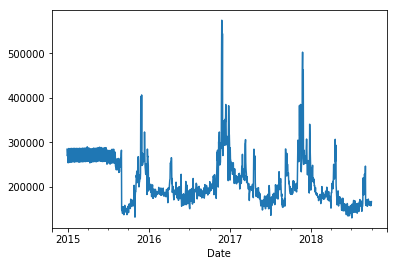

In [10]:
# first visual how how the data look like
# Is it better to resample to week?
traffic_org.seo_visits.plot();

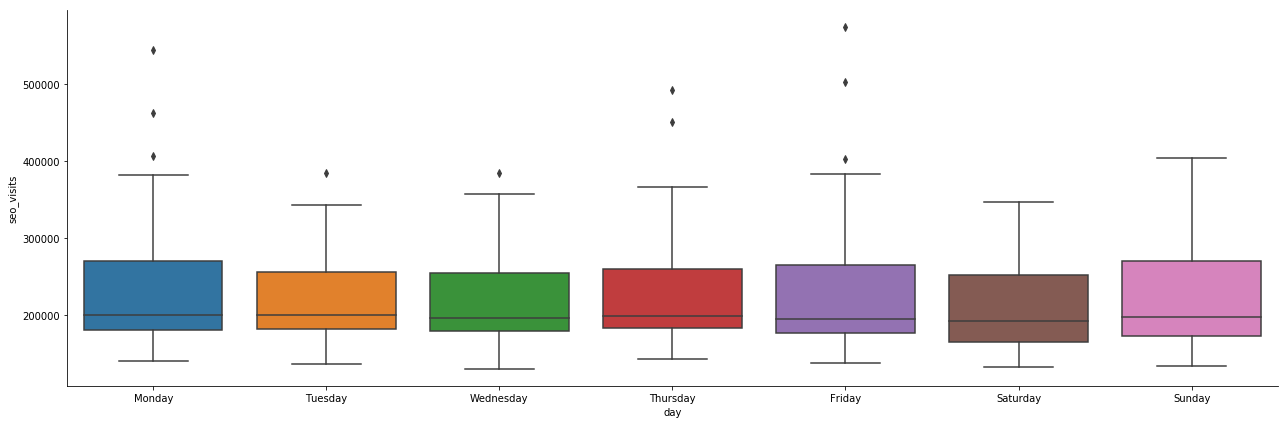

In [11]:
# check if weekday has particular impact to site traffic. It looks like Monday, Friday, and Sunday has higher traffic
# Mean traffic are pretty close for all weekdays, indicate that day may not be a highly correlated factor for traffic
sns.factorplot(x='day', y='seo_visits', data=traffic_org, kind='box', size=6, aspect=3);

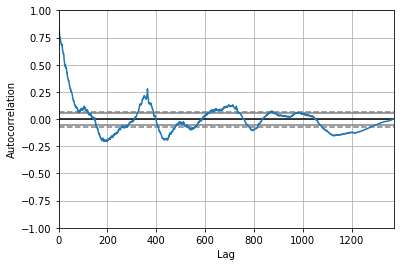

In [12]:
# Check coorelation among date, appears some recurring pattern
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(traffic_org.seo_visits);

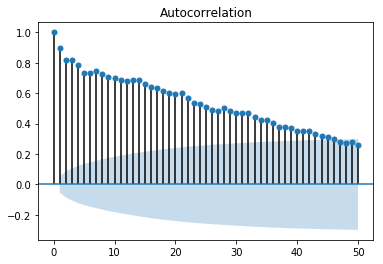

In [13]:
# Need help on interpret this
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(traffic_org.seo_visits.values, lags=50)
plt.show()

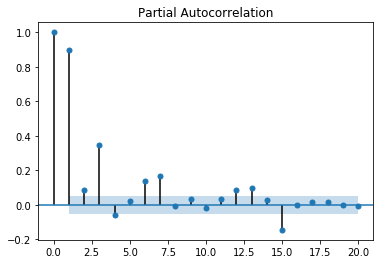

In [14]:
# plt.subplot(122)
plot_pacf(traffic_org.seo_visits.values, lags=20)
plt.show()
# a lag of 7 maybe meaningful

<Figure size 432x288 with 0 Axes>

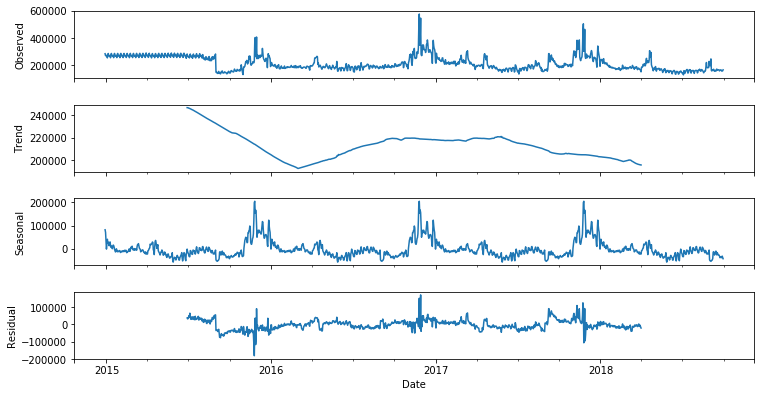

In [15]:
# traffic picked up during 2016 & 2017, but show declining trend in 2018
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(traffic_org.seo_visits, freq=365) 
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(12, 6)

In [16]:
# test data stationary
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Performing the Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

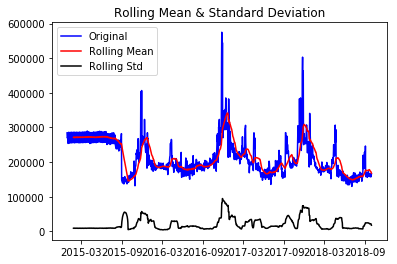

Results of Dickey-Fuller Test:
Test Statistic                   -3.431802
p-value                           0.009921
#Lags Used                       21.000000
Number of Observations Used    1350.000000
Critical Value (1%)              -3.435203
Critical Value (5%)              -2.863683
Critical Value (10%)             -2.567911
dtype: float64


In [17]:
# test statistic is less than 5%, assume data are stationary
test_stationarity(traffic_org.seo_visits)

In [19]:
# Create train and test set
train = traffic_org['2015-09':'2018-03']
test = traffic_org['2018-03':]

In [25]:
# Go through 7 tests, which are naive, simple average, moving average, simple exponential, Holt linear, Holt Winter, and ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
dd = np.asarray(train.seo_visits)
y_hat = test.copy()

y_hat['naive'] = dd[len(dd)-1]
y_hat['simple_avg'] = train.seo_visits.mean()
y_hat['moving_avg'] = train.seo_visits.rolling(13).mean().iloc[-1]
y_hat['simple_exp'] = SimpleExpSmoothing(dd).fit(smoothing_level=0.6,optimized=False).forecast(len(test))
y_hat['holt'] = Holt(dd, damped=True).fit(smoothing_level = 0.3,smoothing_slope = 0.1).forecast(len(test))
y_hat['holt_winter'] = ExponentialSmoothing(dd, seasonal_periods=52, trend='add', seasonal='add').fit().forecast(len(test))
# How to know to what to pick on order? Simple version - ARIMA
# y_hat['ARIMA'] = ARIMA(train.seo_visits, order=(7, 1, 0)).fit(disp=0).predict(start="2018-03-01", end="2018-09-30", dynamic=True)
y_hat['ARIMA'] = sm.tsa.statespace.SARIMAX(train.seo_visits, order=(2, 1, 1),seasonal_order=(0,1,1,7)).fit().predict(start="2018-03-01", end="2018-09-30", dynamic=True)

C:\Users\SIT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [26]:
# build out the RMSE table
from sklearn.metrics import mean_squared_error
from math import sqrt

rms_table = pd.DataFrame()
rms = sqrt(mean_squared_error(test.seo_visits, y_hat.naive))
rms_table.loc['naive','rmse'] = rms
rms = sqrt(mean_squared_error(test.seo_visits, y_hat.simple_avg))
rms_table.loc['simple_avg','rmse'] = rms
rms = sqrt(mean_squared_error(test.seo_visits, y_hat.moving_avg))
rms_table.loc['moving_avg','rmse'] = rms
rms = sqrt(mean_squared_error(test.seo_visits, y_hat.simple_exp))
rms_table.loc['simple_exp','rmse'] = rms
rms = sqrt(mean_squared_error(test.seo_visits, y_hat.holt))
rms_table.loc['holt','rmse'] = rms
rms = sqrt(mean_squared_error(test.seo_visits, y_hat.holt_winter))
rms_table.loc['holt_winter','rmse'] = rms
rms = sqrt(mean_squared_error(test.seo_visits, y_hat.ARIMA))
rms_table.loc['ARIMA','rmse'] = rms

rms_table

,rmse
naive,28335.251708
simple_avg,45139.375407
moving_avg,26216.929456
simple_exp,26932.227660
holt,26027.118192
holt_winter,34722.945935
ARIMA,24210.543743


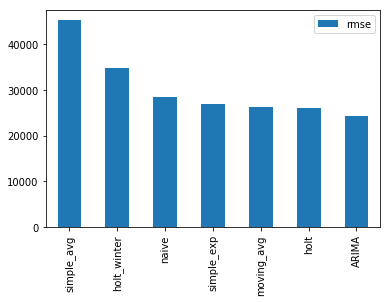

In [27]:
# summary of accuarcy performance
rms_table.sort_values(by='rmse', ascending=False).plot(kind='bar');

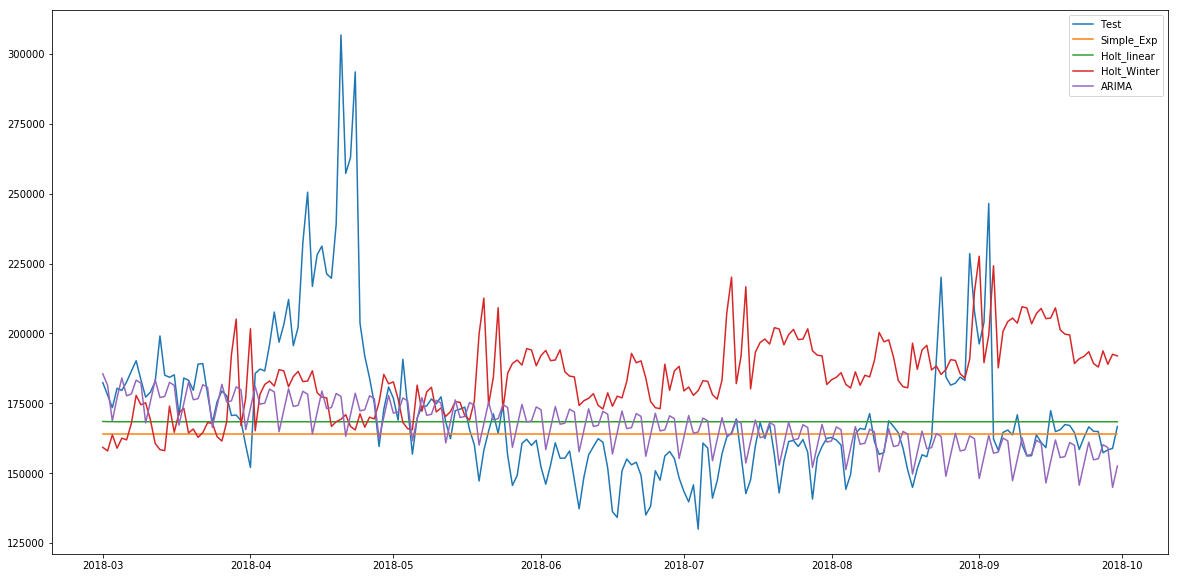

In [29]:
# visualize all results
plt.figure(figsize=(20,10))
# plt.plot(train['seo_visits'], label='Train')
plt.plot(test['seo_visits'], label='Test')
# plt.plot(y_hat['naive'], label='Naive')
# plt.plot(y_hat['simple_avg'], label='Simple_Avg')
# plt.plot(y_hat['moving_avg'], label='Moving_Avg')
plt.plot(y_hat['simple_exp'], label='Simple_Exp')
plt.plot(y_hat['holt'], label='Holt_linear')
plt.plot(y_hat['holt_winter'], label='Holt_Winter')
plt.plot(y_hat['ARIMA'], label='ARIMA')
plt.legend(loc='best')
plt.show()

In [ ]:
# Conclusion - while ARIMA has the best accuracy, it lack the seasonalty spike the business experience. 
# I will use ARIMA as the basline and re-seasonalize with other technic

In [37]:
# How to add future date and predicted values from Holt Winter and ARIMA
future = pd.DataFrame()

In [ ]:
future['simple_exp'] = SimpleExpSmoothing(traffic_org.seo_visits).fit(smoothing_level=0.6,optimized=False).forecast(365)
future['holt'] = Holt(traffic_org.seo_visits, damped=True).fit(smoothing_level = 0.3,smoothing_slope = 0.1).forecast(365)
future['holt_winter'] = ExponentialSmoothing(traffic_org.seo_visits, seasonal_periods=52, trend='add', seasonal='add').fit().forecast(365)
future['ARIMA'] = sm.tsa.statespace.SARIMAX(traffic_org.seo_visits, order=(2, 1, 1),seasonal_order=(0,1,1,7)).fit().predict(start="2018-03-01", end="2019-03-30", dynamic=True)

C:\Users\SIT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SIT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\SIT\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
future